In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/chanyoung/Desktop/Neural-GC-master/lorenz_96_10_10_1000.csv')
X = df[['a','b']].values

In [2]:
def data_split(X, timelag = 10):
    data = []
    Y = []
    for i in range(len(X) - 11):
        data.append(X[i:i+10])
        Y.append(X[i+11])

    return data, Y

In [170]:
import numpy as np

class RBFtimenet2d(object):
    # This is one layer RBFnn, one-dims
    def __init__(self, timelag = 10, lr = 0.01, epochs = 100, inferStds = True, seed = 1234):
        self.lr = lr
        self.epochs = epochs
        self.inferStds = inferStds
        self.seed = seed
        self.timelag = timelag
        np.random.seed(self.seed)


    def cluster(self, X):
        # simple cluster means and stds list about time series data
        clusters = []
        stds = []
        cov = []
        for x in X:

            clu1, clu2 = np.mean(x[:, 0]), np.mean(x[:, 1])
            clusters.append([clu1, clu2])
            
            '''
            std1, std2 = np.std(x[:, 0]), np.std(x[:, 1])
            stds.append([std1, std2])
            '''
            cov.append(np.cov((x.T)))

        return clusters, cov
        # 확인 완료

    def rbf(self, x, clusters, cov):
        return np.exp(-1*((x[0] -clusters[0])**2 + (x[1] - clusters[1])**2)/
                      (np.linalg.inv(cov) * np.linalg.inv(cov)))

    def fit(self, X, y):

        self.c, self.cov = self.cluster(X)
        self.w = np.random.randn(len(X),2,2)
        self.b= np.random.randn(len(X),1)


        # training
        loss_list = []
        loss_mean_list = []
        F_list_epoch = []
        for epoch in range(self.epochs):
            loss_list2 = []
            print('{} epoch train'.format(epoch))
            pred_list = []
            for i in range(len(X)):
                rbf_x = np.array([self.rbf(x, self.c[i], self.cov[i]) for x in X[i]])
                rbf_w = sum([rbf_.dot(self.w[i]) for rbf_ in rbf_x])

                F = rbf_w[0][0] + rbf_w[1][1] + self.b[i]
                
                loss = -(y[i][0] - F)
                
                # loss predict value save
                loss_list2.append(np.abs(loss))
                pred_list.append(F)

                # weight, bias, center, sigma update
                self.w[i][0][0] += self.lr * rbf_w[0][0] *loss
                self.w[i][1][0] += self.lr * rbf_w[1][0] *loss
                self.w[i][0][1] += self.lr * rbf_w[0][1] *loss
                self.w[i][1][1] += self.lr * rbf_w[1][1] *loss
                self.b[i] += self.lr * loss
                
                self.c[i] += self.lr * loss
                self.cov[i] += self.lr * loss
                
            F_list_epoch.append(pred_list)
            loss_list.append(loss_list2)
            loss_mean_list.append(np.mean(loss_list2))
            print("{} epoch loss:".format(epoch), np.mean(loss_list2))
            print('---------------------------------------')
            print()

            if epoch >= 5 and (loss_mean_list[epoch] > min(loss_mean_list[epoch - 5:epoch - 1])):
                print("early stopping at {} epoch".format(epoch))
                return loss_mean_list, F_list_epoch, loss_list

            else:
                continue

        return loss_mean_list, F_list_epoch, loss_list

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data load
df = pd.read_csv('C:/Users/chanyoung/Desktop/Neural-GC-master/lorenz_96_10_10_1000.csv')
X2d = df[['a','b']].values

# data fit
lag = 10
X_2d, Y = data_split(X2d,timelag = lag)
rbfnet2d = RBFtimenet2d(timelag = lag,lr=1e-3,epochs = 100)
loss_mean_list, F_list_epoch, loss_list = rbfnet2d.fit(X_2d, Y)

0 epoch train
0 epoch loss: 4.119918585131479
---------------------------------------

1 epoch train
1 epoch loss: 4.092278567899276
---------------------------------------

2 epoch train
2 epoch loss: 4.090409478464298
---------------------------------------

3 epoch train
3 epoch loss: 4.092331831261195
---------------------------------------

4 epoch train
4 epoch loss: 4.095367598824796
---------------------------------------

5 epoch train
5 epoch loss: 4.099100848649698
---------------------------------------

early stopping at 5 epoch


In [200]:
rbfnet2d.w

array([[[ 0.47143516, -1.19097569],
        [ 1.43270697, -0.3126519 ]],

       [[-0.72058873,  0.88716294],
        [ 0.85958841, -0.6365235 ]],

       [[ 0.01569637, -2.24268495],
        [ 1.15003572,  0.99194602]],

       ...,

       [[-0.33241503,  1.46382703],
        [ 0.95034459,  0.54753736]],

       [[-0.32987299, -1.24772996],
        [-1.32019909,  0.96369394]],

       [[-1.12131155, -0.50908975],
        [-0.38937647,  0.15067387]]])

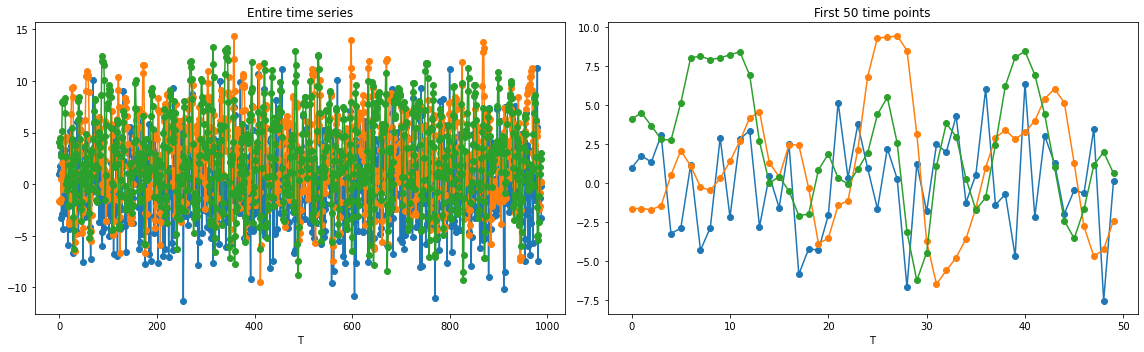

In [7]:
# data plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

axarr[0].plot(F_list_epoch[3],'-o', label='RBF-Net')
axarr[0].plot(Y,'-o', label='True')
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')

axarr[1].plot(F_list_epoch[3][:50],'-o', label='true')
axarr[1].plot(Y[:50],'-o', label='true')

axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')

plt.tight_layout()
plt.show()

In [8]:
class RBFtimenet(object):
    # This is one layer RBFnn
    def __init__(self, timelag = 10, lr = 0.01, epochs = 100, inferStds = True, seed = 1234):
        self.lr = lr
        self.epochs = epochs
        self.inferStds = inferStds
        self.seed = seed
        self.timelag = timelag
        np.random.seed(self.seed)


    def cluster(self, X):
        # simple cluster means and stds list about time series data
        clusters = [np.mean(x) for x in X]
        stds = [np.std(x) for x in X]

        return clusters, stds

    def rbf(self, x, clusters, stds):
        return np.exp(-1 / (2 * stds**2) * (x-clusters)**2)

    def fit(self, X, y):

        self.c, self.s = self.cluster(X)

        self.w = np.random.randn(len(X), self.timelag)
        self.b = np.random.randn(len(X),1)

        # training
        loss_list = []
        loss_mean_list = []
        F_list_epoch = []
        for epoch in range(self.epochs):
            loss_list2 = []
            print('{} epoch train'.format(epoch))
            pred_list = []
            for i in range(len(X)):
                rbf_x = np.array([self.rbf(x, self.c[i], self.s[i]) for x in X[i]])
                F = rbf_x.T.dot(self.w[i]) + self.b[i]
                loss = -(y[i] - F)

                # loss predict value save
                loss_list2.append(np.abs(loss))
                pred_list.append(F)
            
                # weight, bias, center, sigma update
                self.w[i] -= self.lr * rbf_x.reshape(10,) * loss
                self.b[i] -= self.lr * loss
                self.c[i] += self.lr * loss
                self.s[i] += self.lr * loss

            F_list_epoch.append(pred_list)
            loss_list.append(loss_list2)
            loss_mean_list.append(np.mean(loss_list2))
            print("{} epoch loss:".format(epoch), np.mean(loss_list2))
            print('---------------------------------------')

            if epoch >= 5 and (loss_mean_list[epoch] > min(loss_mean_list[epoch - 5:epoch - 1])):
                print("early stopping at {} epoch".format(epoch))
                return loss_mean_list, F_list_epoch, loss_list

            else:
                continue

        return loss_mean_list, F_list_epoch, loss_list


In [9]:
X = df['a'].values
X_, Y = data_split(X)
rbfnet = RBFtimenet(timelag = 10,lr=1e-3,epochs = 1000)
loss_mean_list, F_list_epoch, loss_list = rbfnet.fit(X_, Y)

0 epoch train
0 epoch loss: 4.312145545569957
---------------------------------------
1 epoch train
1 epoch loss: 4.2850322286539555
---------------------------------------
2 epoch train
2 epoch loss: 4.258140535090908
---------------------------------------
3 epoch train
3 epoch loss: 4.231468683008874
---------------------------------------
4 epoch train
4 epoch loss: 4.2050148964627265
---------------------------------------
5 epoch train
5 epoch loss: 4.178777405762779
---------------------------------------
6 epoch train
6 epoch loss: 4.1527544478212075
---------------------------------------
7 epoch train
7 epoch loss: 4.126944266516464
---------------------------------------
8 epoch train
8 epoch loss: 4.101345113075726
---------------------------------------
9 epoch train
9 epoch loss: 4.075955246475322
---------------------------------------
10 epoch train
10 epoch loss: 4.050772933858829
---------------------------------------
11 epoch train
11 epoch loss: 4.025796450972325
-

93 epoch loss: 2.5377568984537047
---------------------------------------
94 epoch train
94 epoch loss: 2.524947593508632
---------------------------------------
95 epoch train
95 epoch loss: 2.512240580772231
---------------------------------------
96 epoch train
96 epoch loss: 2.499633314467431
---------------------------------------
97 epoch train
97 epoch loss: 2.487124590678842
---------------------------------------
98 epoch train
98 epoch loss: 2.474715299106832
---------------------------------------
99 epoch train
99 epoch loss: 2.4624072565493527
---------------------------------------
100 epoch train
100 epoch loss: 2.4502021264199607
---------------------------------------
101 epoch train
101 epoch loss: 2.438101063871876
---------------------------------------
102 epoch train
102 epoch loss: 2.4261047757981133
---------------------------------------
103 epoch train
103 epoch loss: 2.414213675494391
---------------------------------------
104 epoch train
104 epoch loss: 2.4

185 epoch loss: 1.6953734626082104
---------------------------------------
186 epoch train
186 epoch loss: 1.6890373599063142
---------------------------------------
187 epoch train
187 epoch loss: 1.6827633284068007
---------------------------------------
188 epoch train
188 epoch loss: 1.6765659081289468
---------------------------------------
189 epoch train
189 epoch loss: 1.6705140367339275
---------------------------------------
190 epoch train
190 epoch loss: 1.6646401465512666
---------------------------------------
191 epoch train
191 epoch loss: 1.6588927677091896
---------------------------------------
192 epoch train
192 epoch loss: 1.6531820123792254
---------------------------------------
193 epoch train
193 epoch loss: 1.6474359422542302
---------------------------------------
194 epoch train
194 epoch loss: 1.6416384752105257
---------------------------------------
195 epoch train
195 epoch loss: 1.63581622020008
---------------------------------------
196 epoch train
1

277 epoch loss: 1.2674306341383006
---------------------------------------
278 epoch train
278 epoch loss: 1.2638681299405516
---------------------------------------
279 epoch train
279 epoch loss: 1.2603200739673939
---------------------------------------
280 epoch train
280 epoch loss: 1.2567802836297923
---------------------------------------
281 epoch train
281 epoch loss: 1.2531428599843855
---------------------------------------
282 epoch train
282 epoch loss: 1.2494637035584872
---------------------------------------
283 epoch train
283 epoch loss: 1.245849844978991
---------------------------------------
284 epoch train
284 epoch loss: 1.2422852878185566
---------------------------------------
285 epoch train
285 epoch loss: 1.238751320474809
---------------------------------------
286 epoch train
286 epoch loss: 1.2352409331205745
---------------------------------------
287 epoch train
287 epoch loss: 1.231744433512608
---------------------------------------
288 epoch train
28

368 epoch loss: 1.0160589088614536
---------------------------------------
369 epoch train
369 epoch loss: 1.0139770413473117
---------------------------------------
370 epoch train
370 epoch loss: 1.0118820889277647
---------------------------------------
371 epoch train
371 epoch loss: 1.0097632969367878
---------------------------------------
372 epoch train
372 epoch loss: 1.0076367587515362
---------------------------------------
373 epoch train
373 epoch loss: 1.0055213101982143
---------------------------------------
374 epoch train
374 epoch loss: 1.00342574962627
---------------------------------------
375 epoch train
375 epoch loss: 1.0013516516495342
---------------------------------------
376 epoch train
376 epoch loss: 0.9992993503632606
---------------------------------------
377 epoch train
377 epoch loss: 0.9972714140150319
---------------------------------------
378 epoch train
378 epoch loss: 0.9952720458828549
---------------------------------------
379 epoch train
3

460 epoch loss: 0.8517555356564237
---------------------------------------
461 epoch train
461 epoch loss: 0.8498975742747903
---------------------------------------
462 epoch train
462 epoch loss: 0.8480361779525841
---------------------------------------
463 epoch train
463 epoch loss: 0.8461759918439157
---------------------------------------
464 epoch train
464 epoch loss: 0.8443206265930012
---------------------------------------
465 epoch train
465 epoch loss: 0.8424731101222032
---------------------------------------
466 epoch train
466 epoch loss: 0.8406360714604668
---------------------------------------
467 epoch train
467 epoch loss: 0.8388116282578272
---------------------------------------
468 epoch train
468 epoch loss: 0.8370013075398719
---------------------------------------
469 epoch train
469 epoch loss: 0.8352061505302292
---------------------------------------
470 epoch train
470 epoch loss: 0.8334269085667904
---------------------------------------
471 epoch train

553 epoch loss: 0.7142050062394114
---------------------------------------
554 epoch train
554 epoch loss: 0.7128463015855998
---------------------------------------
555 epoch train
555 epoch loss: 0.7114599640574577
---------------------------------------
556 epoch train
556 epoch loss: 0.7100288994161988
---------------------------------------
557 epoch train
557 epoch loss: 0.7085559734682694
---------------------------------------
558 epoch train
558 epoch loss: 0.7070648925630012
---------------------------------------
559 epoch train
559 epoch loss: 0.7055795580576899
---------------------------------------
560 epoch train
560 epoch loss: 0.7041089187692915
---------------------------------------
561 epoch train
561 epoch loss: 0.7026543495047491
---------------------------------------
562 epoch train
562 epoch loss: 0.7012163189918246
---------------------------------------
563 epoch train
563 epoch loss: 0.6997951661626863
---------------------------------------
564 epoch train

645 epoch loss: 0.5945463750373134
---------------------------------------
646 epoch train
646 epoch loss: 0.5933527434643331
---------------------------------------
647 epoch train
647 epoch loss: 0.5921646919130398
---------------------------------------
648 epoch train
648 epoch loss: 0.5909806086146941
---------------------------------------
649 epoch train
649 epoch loss: 0.5898005750587411
---------------------------------------
650 epoch train
650 epoch loss: 0.588625695301766
---------------------------------------
651 epoch train
651 epoch loss: 0.5874574940089212
---------------------------------------
652 epoch train
652 epoch loss: 0.5862975223845198
---------------------------------------
653 epoch train
653 epoch loss: 0.5851471361905431
---------------------------------------
654 epoch train
654 epoch loss: 0.584007388759446
---------------------------------------
655 epoch train
655 epoch loss: 0.582878961770356
---------------------------------------
656 epoch train
65

In [103]:
CD = np.log(np.var(rbfnet2d.b)/np.var(rbfnet.b))

In [104]:
CD

-0.5482462365773146

In [12]:
from scipy.stats import f_oneway

In [33]:
f_oneway(rbfnet2d.w_x2,np.zeros((989,10)))

F_onewayResult(statistic=array([3.14898379, 1.91251912, 0.01021517, 0.13025122, 0.06140275,
       0.33619565, 0.19725536, 1.44278323, 0.37958029, 0.25043086]), pvalue=array([0.0761282 , 0.16683995, 0.91950504, 0.71821029, 0.80431816,
       0.56209955, 0.65699405, 0.22983344, 0.53789891, 0.61682759]))

In [74]:
rbfnet2d.w_x2.T.shape

(10, 989)

 b -> a